In [4]:
from tslearn.datasets import UCR_UEA_datasets
import matplotlib.pyplot as plt

In [2]:
dataset='ItalyPowerDemand'
train_x,train_y, test_x, test_y=UCR_UEA_datasets().load_dataset(dataset)
train_y = train_y-1
test_y = test_y-1

/tmp/ipykernel_4664/1765650336.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


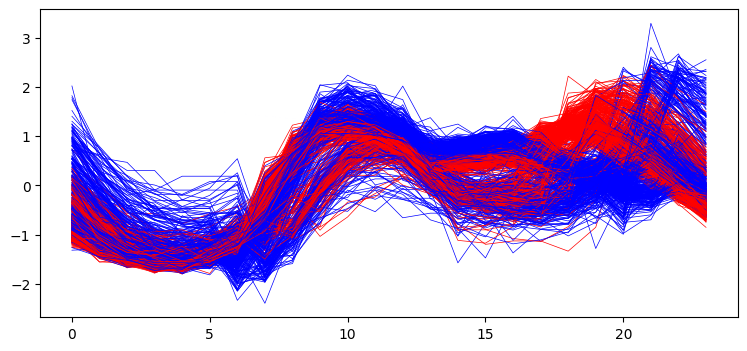

In [5]:
color = []
for label in test_y:
    if label ==0:
        color.append('red')
    else:
        color.append('blue')


fig, ax = plt.subplots(figsize=(9,4))
[ax.plot(test_x[i,:,0].T,c=color[i],lw=0.5) for i in range(test_x.shape[0])]

fig.show()

In [6]:
import numpy as np
import pandas as pd

class FrequencyDomainProcessor:
    """
    A class to transform a 1D time-series signal from a DataFrame
    to the frequency domain, modify it, and reconstruct it back.
    """
    def __init__(self, df, signal_col, sampling_rate):
        """
        Initialize the processor.

        Parameters
        ----------
        df : pandas.DataFrame
            The dataframe containing the signal.
        signal_col : str
            The column name with the signal values.
        sampling_rate : float
            Sampling frequency in Hz.
        """
        self.df = df.copy()
        self.signal_col = signal_col
        self.fs = sampling_rate

        # Extract signal and time
        self.signal = self.df[signal_col].values
        self.N = len(self.signal)
        self.freqs = np.fft.fftfreq(self.N, d=1/self.fs)
        self.fft_signal = None
        self.modified_fft = None
        self.reconstructed_signal = None
        self.noise = None
        #self.filter_type = None

    def fft(self):
        """Compute FFT of the signal and store it."""
        self.fft_signal = np.fft.fft(self.signal,norm='ortho')#/(len(self.signal)/2)
        return self.fft_signal, self.freqs

    def apply_filter(self, filter_type='lowpass', cutoff=None,noise_level =0.10,mask=None):
        """
        Modify the signal in the frequency domain.

        Parameters
        ----------
        filter_type : str
            One of {'lowpass', 'highpass', 'bandpass'}.
        cutoff : float or tuple
            Cutoff frequency/frequencies (Hz).
            - lowpass: single value (e.g. 100)
            - highpass: single value (e.g. 100)
            - bandpass: tuple (low, high)
        """
        self.filter_type = filter_type

        if self.fft_signal is None:
            raise ValueError("Run fft() before filtering.")

        X_mod = self.fft_signal.copy()#/(len(self.fft_signal/2))
        f = np.abs(self.freqs)
        #print(len(f))

        if filter_type == 'lowpass':
            X_mod[f > cutoff] = 0
        elif filter_type == 'highpass':
            X_mod[f < cutoff] = 0
        elif filter_type =='Mask':
            X_mod[mask] = 0
        elif filter_type == 'bandpass':
            if not isinstance(cutoff, (list, tuple)) or len(cutoff) != 2:
                raise ValueError("For bandpass, cutoff must be (low, high).")
            low, high = cutoff
            X_mod[(f < low) | (f > high)] = 0
        elif filter_type =="noise":
            np.random.seed(0)
            noise = np.random.normal(0,noise_level,size=len(X_mod))#(np.random.rand(len(X_mod)) - 0.5) * np.max(np.abs(X_mod)) * noise_level 
            X_mod += noise
            self.noise = noise
        elif filter_type== None:
            pass
        else:
            raise ValueError("Invalid filter_type. Use 'lowpass', 'highpass', or 'bandpass'.")

        self.modified_fft = X_mod
        return X_mod

    def ifft(self):
        """Reconstruct the time-domain signal from the modified FFT."""
        if self.modified_fft is None:
            raise ValueError("No modified FFT found. Run apply_filter() first.")
        self.reconstructed_signal = np.real(np.fft.ifft(self.modified_fft, norm='ortho'))#*(len(self.modified_fft)/2)))
        self.df[self.signal_col + '_filtered'] = self.reconstructed_signal
        if self.filter_type == 'noise':
            self.df['noise_time_domain'] = np.real(np.fft.ifft(self.noise,norm='ortho'))
        return self.reconstructed_signal

    def get_filtered_dataframe(self):
        """Return the DataFrame containing the original and filtered signals."""
        if self.reconstructed_signal is None:
            raise ValueError("Reconstructed signal not found. Run ifft() first.")
        return self.df


In [7]:
import pandas as pd

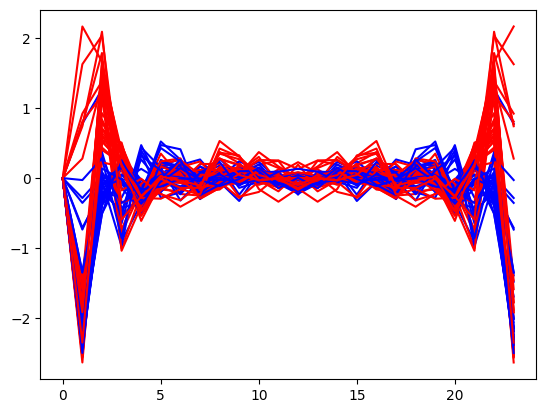

In [63]:
Spectrum_1 = {}
Spectrum_2 = {}
i=0
for series,label in zip(train_x[:,:,0],train_y):

    df = pd.DataFrame({'Value':series.T})

    processor = FrequencyDomainProcessor(df, signal_col='Value', sampling_rate=len(df))
    processor.fft()
    processor.apply_filter(filter_type=None)
    processor.ifft()



    if label==0:
        color = 'blue'
        Spectrum_1[i] = processor.modified_fft
    else:
        Spectrum_2[i]= processor.modified_fft
        color = 'red'
    plt.plot(processor.modified_fft,c=color)
    i+=1



<Axes: >

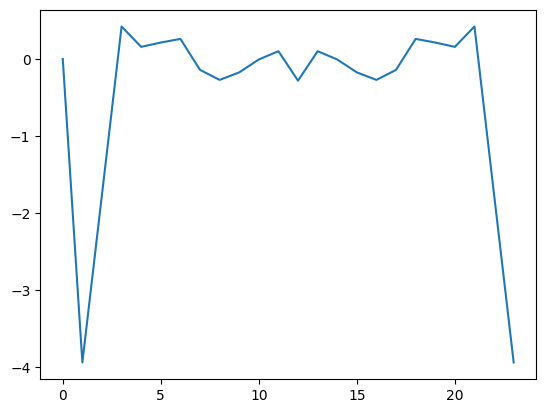

In [75]:
(pd.DataFrame(Spectrum_1).mean(axis=1)-Spectrum_2[2]).plot()

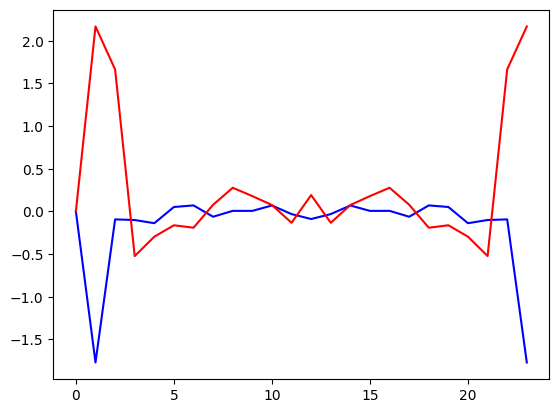

In [78]:
Mean_Spec1 = pd.DataFrame(Spectrum_1).mean(axis=1)
Mean_Spec2 = pd.DataFrame(Spectrum_2).mean(axis=1)



plt.plot(Mean_Spec1,color='blue')
plt.plot(Spectrum_2[2],color='red')

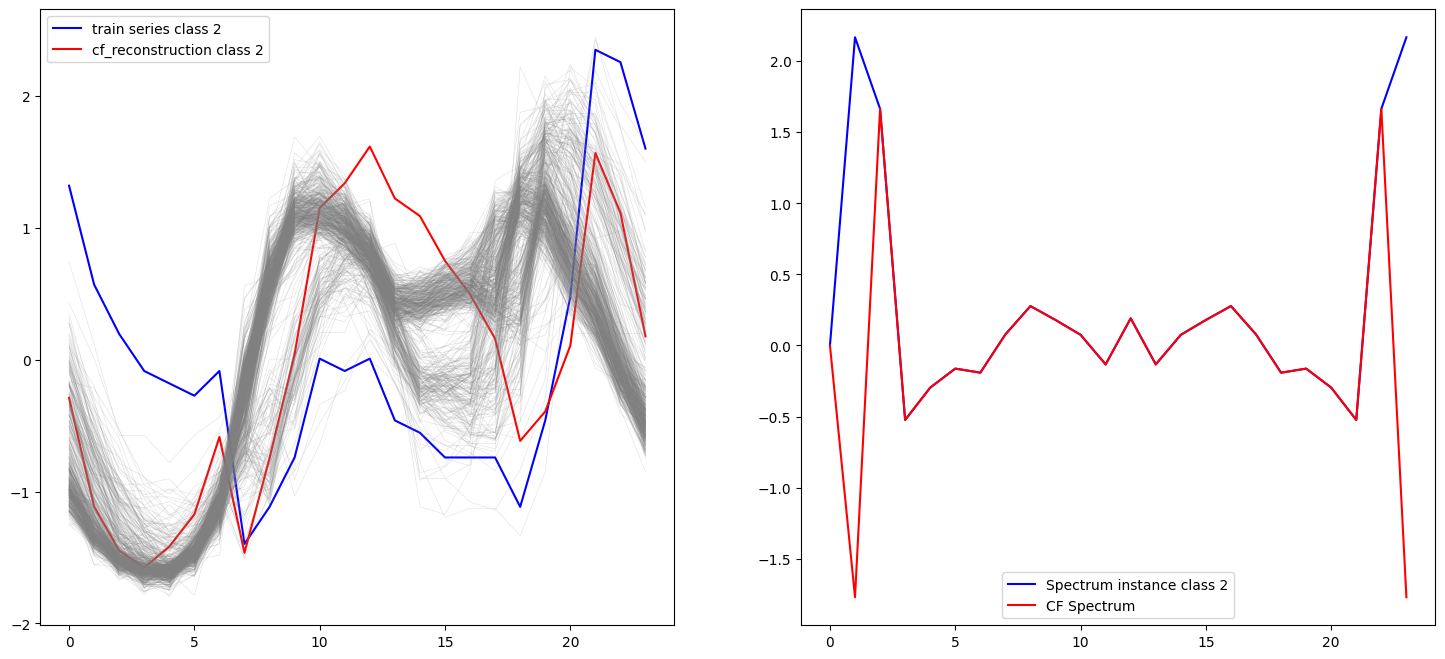

In [80]:
## make max difference in spectrum to mean spectrum of counterfactual class
i=2
diff = np.abs(Mean_Spec1-Spectrum_2[i])

fig, ax = plt.subplots(1,2,figsize=(18,8))
cf_spectrum = np.where(diff == np.max(diff),Mean_Spec1,Spectrum_2[i])
ax[1].plot(Spectrum_2[i],label='Spectrum instance class 2',color='blue')
ax[1].plot(cf_spectrum,label = 'CF Spectrum ',color='red')

ax[1].legend()

processor.modified_fft = Spectrum_2[i]
processor.ifft()
pred = hc2.predict(processor.reconstructed_signal.reshape(1,-1))[0]+1

ax[0].plot(processor.reconstructed_signal,label=f'train series class {pred}',color='blue')


processor.modified_fft = cf_spectrum
processor.ifft()

cf_pred = hc2.predict(processor.reconstructed_signal.reshape(1,-1))[0]+1
ax[0].plot(processor.reconstructed_signal,label=f'cf_reconstruction class {cf_pred}',color='red')


[ax[0].plot(test_x[i,:,0].T,c='gray',alpha=0.2,lw=0.5) for i in range(test_x.shape[0]) if test_y[i]==0]
ax[0].legend()
fig.show()


### Short time fourier transform

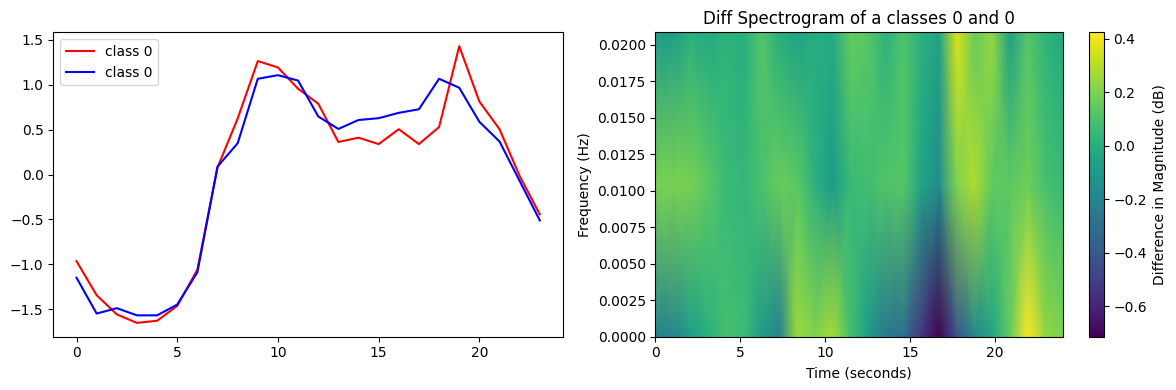

In [357]:
import torch

i=24
stft_result = torch.stft(torch.Tensor(train_x[i,:,0]),n_fft=5,win_length=5,hop_length=1,return_complex=True,normalized=True)
spectrogram = torch.abs(stft_result)


spectrogram_0 = spectrogram#20 * torch.log10(spectrogram + 1e-6).numpy() # Convert to dB scale


j=8
stft_result = torch.stft(torch.Tensor(train_x[j,:,0]),n_fft=5,win_length=5,hop_length=1,return_complex=True,normalized=True)
spectrogram = torch.abs(stft_result)

spectrogram_1 = spectrogram#20 * torch.log10(spectrogram + 1e-6).numpy() # Convert to dB scale


# --- 4. Define Axes for Plotting ---

# Time axis: (N_frames * hop_length) / sample_rate
time_axis = np.linspace(0, 24, spectrogram_0.shape[1])

# Frequency axis: sample_rate / n_fft * (0 to N_frequencies-1)
# N_frequencies is n_fft // 2 + 1
freq_axis = np.linspace(0, 1/24 / 2, spectrogram_0.shape[0])

# --- 5. Plotting ---

fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(train_x[i,:,0],c='red',label=f'class {train_y[i]}')
ax[0].plot(train_x[j,:,0],c='blue',label=f'class {train_y[j]}')
ax[0].legend()
#plt.figure(figsize=(12, 5))

mesh_object = ax[1].pcolormesh(
    time_axis,
    freq_axis,
    spectrogram_0-spectrogram_1,
    shading='gouraud',
    cmap='viridis'
)

cbar = plt.colorbar(
    mesh_object, # The image object you want to map colors from
    ax=ax[1],    # The specific subplot axis to place the colorbar next to
    label='Difference in Magnitude (dB)' # Your descriptive label
)
# Add labels and title
ax[1].set_title(f'Diff Spectrogram of a classes {train_y[i]} and {train_y[j]}')
ax[1].set_ylabel('Frequency (Hz)')
ax[1].set_xlabel('Time (seconds)')
#fig.colorbar(label='Magnitude')
fig.tight_layout()


In [11]:
from sktime.classification.hybrid import HIVECOTEV2

In [114]:
train_x.shape

(67, 24, 1)

In [12]:
hc2 = HIVECOTEV2(time_limit_in_minutes=0.2)
hc2.fit(train_x[:,:,0], train_y)
#y_pred = hc2.predict(test_x[:,:,0])

/home/sven/miniconda3/envs/XAI-TS/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/sven/miniconda3/envs/XAI-TS/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/sven/miniconda3/envs/XAI-TS/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/sven/miniconda3/envs/XAI-TS/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/sven/miniconda3/envs/XAI-TS/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finit

HIVECOTEV2(time_limit_in_minutes=0.2)

In [ ]:
#y_pred = hc2.predict(test_x[:,:,0])

In [82]:
train_y[i]

1

In [81]:
hc2.predict(processor.reconstructed_signal.reshape(1,-1))[0]

1

### Freq_CF

In [234]:
import torch
import torch.nn as nn
import torch.fft as fft

class FrequencyCF(nn.Module):
    def __init__(self, T,delta_init=None):
        super().__init__()
        self.T = T

        # Learnable perturbation (complex)
        if delta_init is None:
            self.delta = nn.Parameter(10*torch.rand(T))
        else:
            print('intit delta')
            self.delta = nn.Parameter(delta_init)
        #self.delta_imag = torch.zeros(T)

    def forward(self, x):
        # FFT: returns complex64
        X = fft.fft(x,norm="ortho")   # shape (B, T)
        self.X = X
        print(f"FFT {X}")
        # Construct complex perturbation
        #delta = self.delta_real + 1j * self.delta_imag
        #delta = delta.unsqueeze(0).expand_as(X)
        
    
        X_cf = X + self.delta
        print(f"Pertubed Spectrum {X_cf}")

        # IFFT – use view_as_real to keep gradients
        x_ifft = fft.ifft(X_cf,norm='ortho')
        x_cf = torch.view_as_real(x_ifft)[..., 0]  # take real component

        return x_cf


In [32]:
train_y[0]
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [246]:
i=2
original_sample = torch.tensor(train_x[i,:,0])
x = original_sample.unsqueeze(0)  # (1, T)
target_label = torch.tensor([0],dtype=torch.float32)

target_spectrum = torch.Tensor(-(Spectrum_1[0]- Spectrum_2[i]).astype('complex'))
print(target_spectrum)
freq_cf = FrequencyCF(T=24,delta_init=None)

optimizer = torch.optim.Adam(freq_cf.parameters(), lr=1e-2)

losses = []

for step in tqdm(range(1)):
    optimizer.zero_grad()

    x_cf = freq_cf(x)                 # perturbed in time domain
    pred = torch.tensor(hc2.predict(x_cf.numpy().reshape(1,-1)),dtype=torch.float32)
    print(pred)

    # Counterfactual objective:
    # 1. make classifier predict the target label
    # 2. keep perturbation small in frequency domain
    classification_loss = nn.BCELoss()(pred, target_label)
    reg_loss = 0#(freq_cf.delta.abs().sum())
                #freq_cf.delta_imag.pow(2).mean())

    loss = classification_loss + 1e-5 * reg_loss
    losses.append(loss.detach().numpy())
    loss.backward()
    optimizer.step()

plt.plot(losses)

tensor([-3.5926e-09,  3.6495e+00,  2.0492e+00, -4.8040e-01, -4.2824e-01,
        -1.2347e-01, -2.9413e-01,  1.6459e-01,  2.8044e-01,  2.1348e-01,
         2.5126e-02, -1.9634e-01,  2.2336e-01, -1.9634e-01,  2.5126e-02,
         2.1348e-01,  2.8044e-01,  1.6459e-01, -2.9413e-01, -1.2347e-01,
        -4.2824e-01, -4.8040e-01,  2.0492e+00,  3.6495e+00])


  0%|          | 0/1 [00:00<?, ?it/s]

FFT tensor([[-8.6957e-09+0.0000j,  2.1679e+00+0.6032j,  1.6646e+00+1.0677j,
         -5.2356e-01+0.8947j, -2.9634e-01+0.8113j, -1.6255e-01-0.4370j,
         -1.9119e-01-0.3824j,  7.7943e-02+0.0420j,  2.7722e-01-0.0166j,
          1.7942e-01-0.1377j,  7.5151e-02+0.0412j, -1.3317e-01+0.3537j,
          1.9119e-01+0.0000j, -1.3317e-01-0.3537j,  7.5151e-02-0.0412j,
          1.7942e-01+0.1377j,  2.7722e-01+0.0166j,  7.7943e-02-0.0420j,
         -1.9119e-01+0.3824j, -1.6255e-01+0.4370j, -2.9634e-01-0.8113j,
         -5.2356e-01-0.8947j,  1.6646e+00-1.0677j,  2.1679e+00-0.6032j]],
       dtype=torch.complex128)
Pertubed Spectrum tensor([[4.2111+0.0000j, 9.8505+0.6032j, 7.1315+1.0677j, 0.1582+0.8947j,
         2.2632+0.8113j, 8.0274-0.4370j, 0.8924-0.3824j, 9.2150+0.0420j,
         1.9846-0.0166j, 5.6853-0.1377j, 4.3118+0.0412j, 3.4971+0.3537j,
         3.2265+0.0000j, 5.0514-0.3537j, 1.2987-0.0412j, 6.3928+0.1377j,
         9.4247+0.0166j, 8.0987-0.0420j, 7.6822+0.3824j, 2.8512+0.4370j,
    

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

Parameter containing:
tensor([7.7710, 5.0332, 0.6527, 5.7617, 5.7430, 5.5201, 3.1381, 3.5022, 8.9126,
        1.2576, 2.4141, 6.1368, 5.3740, 4.7879, 3.0969, 4.0902, 2.6435, 4.7840,
        9.4712, 2.2940, 7.5725, 5.9631, 0.3562, 4.3784], requires_grad=True)

In [223]:
x_cf = fft.fft(torch.tensor(train_x[2,:,0]),norm="ortho")+fft.fft(torch.tensor(train_x[0,:,0]),norm="ortho")-fft.fft(torch.tensor(train_x[2,:,0]),norm="ortho")

In [232]:
hc2.predict(fft.ifft(x_cf).detach().numpy().real.reshape(1,-1))

array([0])

In [ ]:
plt.plot()

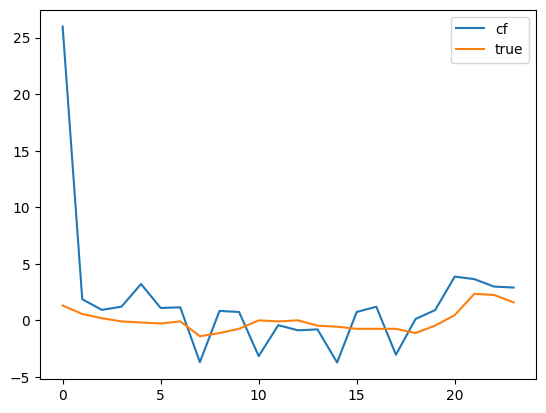

In [243]:
plt.plot(x_cf.detach().cpu().numpy().T,label='cf')
plt.plot(train_x[i],label='true')
plt.legend()

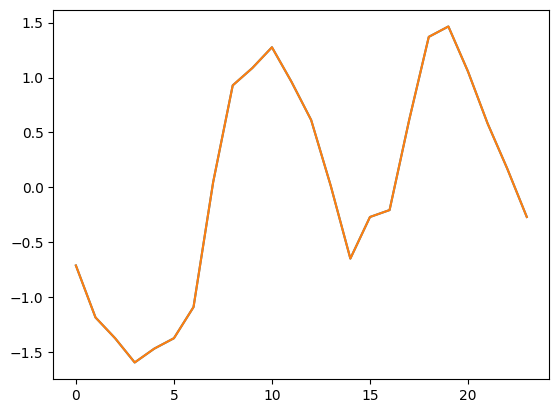

In [266]:
plt.plot(np.fft.ifft(Spectrum_2[2]+Spectrum_1[0]-Spectrum_2[2],norm='ortho'))
plt.plot(train_x[0,:,0])

In [93]:
hc2.predict(x_cf.detach().numpy().reshape(1,-1))


array([1])

In [60]:
train_y[0]

0

In [185]:
train_y[i]

1

In [184]:
hc2.predict(x_cf.detach().cpu().numpy())

array([1])

In [117]:
from sklearn.metrics import accuracy_score

accuracy_score(test_y,y_pred)

0.9611273080660836

In [1]:
from tint.datasets import Arma

arma = Arma()
arma.download()  # This method generates the dataset

/home/sven/miniconda3/envs/XAI-TS/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
inputs = arma.preprocess()["x"][0]
true_saliency = arma.true_saliency(dim=1)[0]

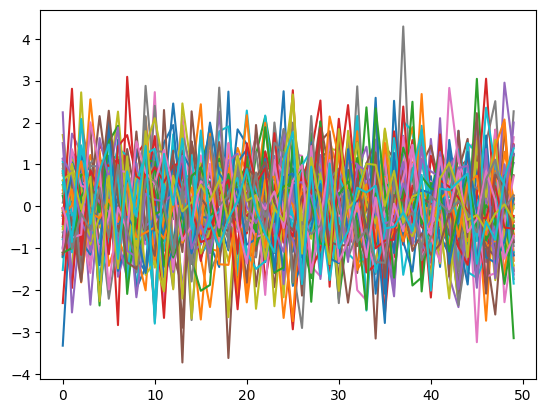

In [7]:
import matplotlib.pyplot as plt


plt.plot(inputs)
plt.show()


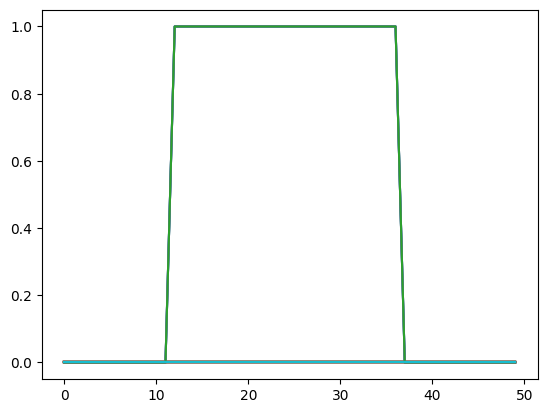

In [16]:
plt.plot(true_saliency)
plt.show()

In [17]:
from tint.attr import TemporalIntegratedGradients

explainer = TemporalIntegratedGradients(arma.get_white_box)

baselines = inputs * 0
attr = explainer.attribute(
    inputs,
    baselines=baselines,
    additional_forward_args=(true_saliency,),
    temporal_additional_forward_args=(True,),
).abs()

In [18]:
from tint.metrics.white_box import aup

print(f"{aup(attr, true_saliency):.4}")

1.0


torch.Size([50, 50])